# Libraries

In [29]:
# general
import numpy as np
import pandas as pd
import os
from itertools import combinations
from pathlib import Path

# dataframes
import pandas as pd
import pyspark as spark


# estadistica
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.weightstats import DescrStatsW

# procesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# aprendizaje no supervisado
from sklearn.decomposition import PCA


# ml & ai
import optuna


# visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec


# api - despliegue




c:\Users\dfoso\anaconda3\envs\dev\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Wizeline - ML Implementing Challenge

## Datasets

In [4]:
# load tabular data from csv file
data = pd.read_csv('data/training_data.csv')

# Define the directory path
directory = 'data/bronze'

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the file
data.to_csv(f'{directory}/data_bronze.csv', index=False)

In [8]:
# ver tipos de variables(independientes)
data.dtypes

feature_0     float64
feature_1     float64
feature_2     float64
feature_3     float64
feature_4     float64
feature_5     float64
feature_6     float64
feature_7     float64
feature_8     float64
feature_9     float64
feature_10    float64
feature_11    float64
feature_12    float64
feature_13    float64
feature_14    float64
feature_15    float64
feature_16    float64
feature_17    float64
feature_18    float64
feature_19    float64
target        float64
dtype: object

## EDA

* Statatistical Analysis
* Descriptive Analysis
* Correlation Techniques
* Variance and Covarianze
* Distrubution Analysis
* Statistical Tests
* Unsupervised Learning Methods
* Outlier Detection


### Statatistical Analysis

* Correlation Analysis:
* Boxplot Distribution Analysis: 
* VIF (Variance Inflation Factor) for Multicollinearity:

In [11]:

def analyze_dataframe(df, output_dir='data/eda/stats/', correlation_threshold=0.5, save_plots=True):
    """
    Performs comprehensive statistical and descriptive analysis on a numeric dataframe.
    Generates visualizations using matplotlib and seaborn.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing numeric data to analyze
    output_dir : str, default='analysis_plots/'
        Directory where to save generated plots
    correlation_threshold : float, default=0.7
        Threshold for highlighting high correlations
    save_plots : bool, default=True
        Whether to save plots to disk
        
    Returns:
    --------
    tuple
        (summary_stats, correlations, outliers_summary, feature_importance, normality_tests)
        All elements are pandas DataFrames containing the analysis results
    """

    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create copies to avoid modifying the original
    df_analysis = df.copy()
    
    # Initialize result DataFrames
    summary_stats = pd.DataFrame()
    correlations = pd.DataFrame()
    outliers_summary = pd.DataFrame()
    feature_importance = pd.DataFrame() 
    normality_tests = pd.DataFrame()
    
    # Basic statistics
    print("Calculating basic statistics...")
    summary_stats = df_analysis.describe().T
    summary_stats['missing'] = df_analysis.isnull().sum()
    summary_stats['missing_pct'] = df_analysis.isnull().mean() * 100
    summary_stats['unique_values'] = df_analysis.nunique()
    
    # Correlation analysis
    print("Performing correlation analysis...")
    correlations = df_analysis.corr()
    
    # Find high correlations (excluding self-correlations)
    high_corr_pairs = []
    for i in range(len(correlations.columns)):
        for j in range(i+1, len(correlations.columns)):
            if abs(correlations.iloc[i, j]) >= correlation_threshold:
                high_corr_pairs.append({
                    'feature1': correlations.columns[i],
                    'feature2': correlations.columns[j],
                    'correlation': correlations.iloc[i, j]
                })
    
    high_correlations = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
    
    # Normality tests
    print("Testing for normality...")
    normality_results = []
    for column in df_analysis.columns:
        # Shapiro-Wilk test (best for smaller datasets)
        shapiro_test = stats.shapiro(df_analysis[column].dropna())
        
        # D'Agostino-Pearson test
        dagostino_test = stats.normaltest(df_analysis[column].dropna())
        
        normality_results.append({
            'feature': column,
            'shapiro_stat': shapiro_test[0],
            'shapiro_p_value': shapiro_test[1],
            'shapiro_normal': shapiro_test[1] > 0.05,
            'dagostino_stat': dagostino_test[0],
            'dagostino_p_value': dagostino_test[1],
            'dagostino_normal': dagostino_test[1] > 0.05
        })
    
    normality_tests = pd.DataFrame(normality_results)
    
    # Calculate VIF (Variance Inflation Factor) for multicollinearity
    X = df_analysis.values
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_analysis.columns
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    
    # Visualization Section
    print("Generating visualizations...")
    
    
    
    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlations, dtype=bool))
    sns.heatmap(correlations, mask=mask, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
    plt.title('Correlation Matrix')
    if save_plots:
        plt.savefig(f"{output_dir}correlation_heatmap.png", dpi=300, bbox_inches='tight')
    
    # Boxplots for outlier detection
    plt.figure(figsize=(15, 10))
    ax = sns.boxplot(data=df_analysis)
    plt.title('Boxplots for Outlier Detection')
    plt.xticks(rotation=90)
    if save_plots:
        plt.savefig(f"{output_dir}boxplots.png", dpi=300, bbox_inches='tight')
    
    # Scatter matrix for top correlated features
    if high_correlations.shape[0] > 0:
        top_correlated = set()
        for _, row in high_correlations.head(5).iterrows():
            top_correlated.add(row['feature1'])
            top_correlated.add(row['feature2'])
        
        top_correlated = list(top_correlated)[:5]  # Limit to 5 features
        
        if len(top_correlated) > 1:
            plt.figure(figsize=(15, 15))
            sns.pairplot(df_analysis[top_correlated])
            plt.suptitle('Pairplot of Top Correlated Features', y=1.02)
            if save_plots:
                plt.savefig(f"{output_dir}pairplot.png", dpi=300, bbox_inches='tight')
    
   

    # Calculate VIF (Variance Inflation Factor) for multicollinearity - excluding 'target' column
    if 'target' in df_analysis.columns:
        # Create a dataframe without the target column for VIF calculation
        df_features = df_analysis.drop('target', axis=1)
        X = df_features.values
        vif_features = df_features.columns
    else:
        # If no target column exists, use all columns
        X = df_analysis.values
        vif_features = df_analysis.columns

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["feature"] = vif_features
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

    # Multicollinearity (VIF) bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='VIF', y='feature', data=vif_data.sort_values('VIF', ascending=False))
    plt.title('Variance Inflation Factor (VIF) for Multicollinearity')
    plt.axvline(x=5, color='r', linestyle='--')  # Common threshold for VIF
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}vif_factors.png", dpi=300, bbox_inches='tight')

    print("Analysis complete!")
    
    # Display all figures if not explicitly saving
    if not save_plots:
        plt.show()
    
    return (summary_stats, correlations, outliers_summary, feature_importance, normality_tests)

Calculating basic statistics...
Performing correlation analysis...
Testing for normality...
Generating visualizations...
Analysis complete!


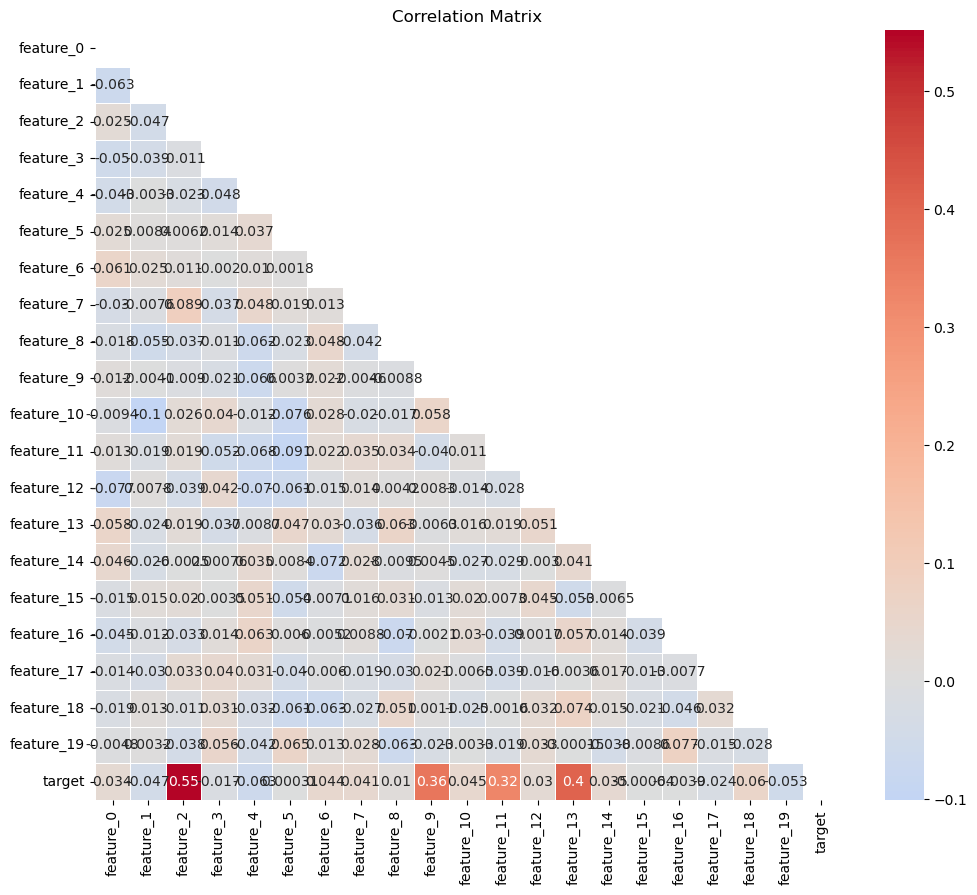

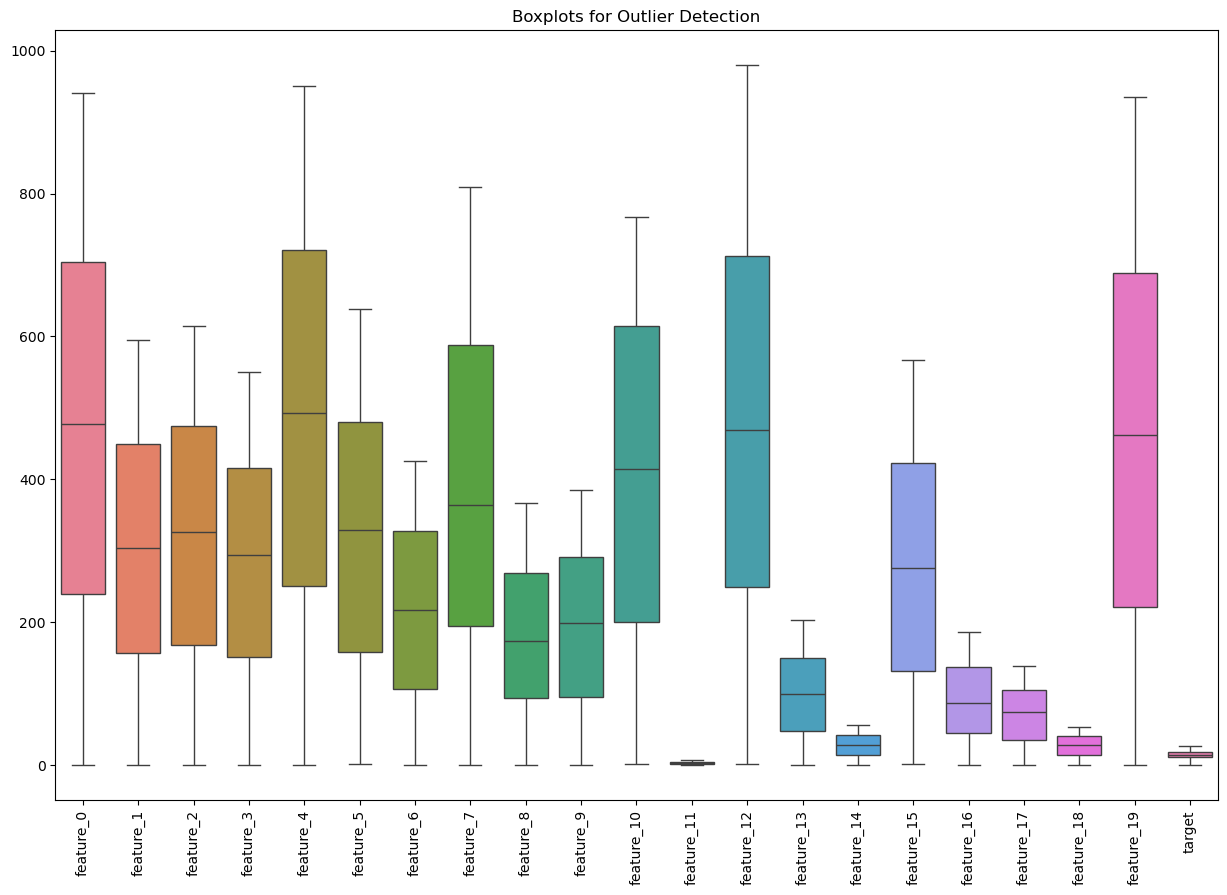

<Figure size 1500x1500 with 0 Axes>

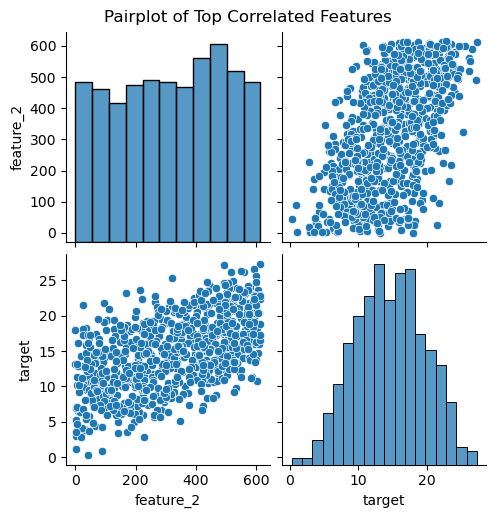

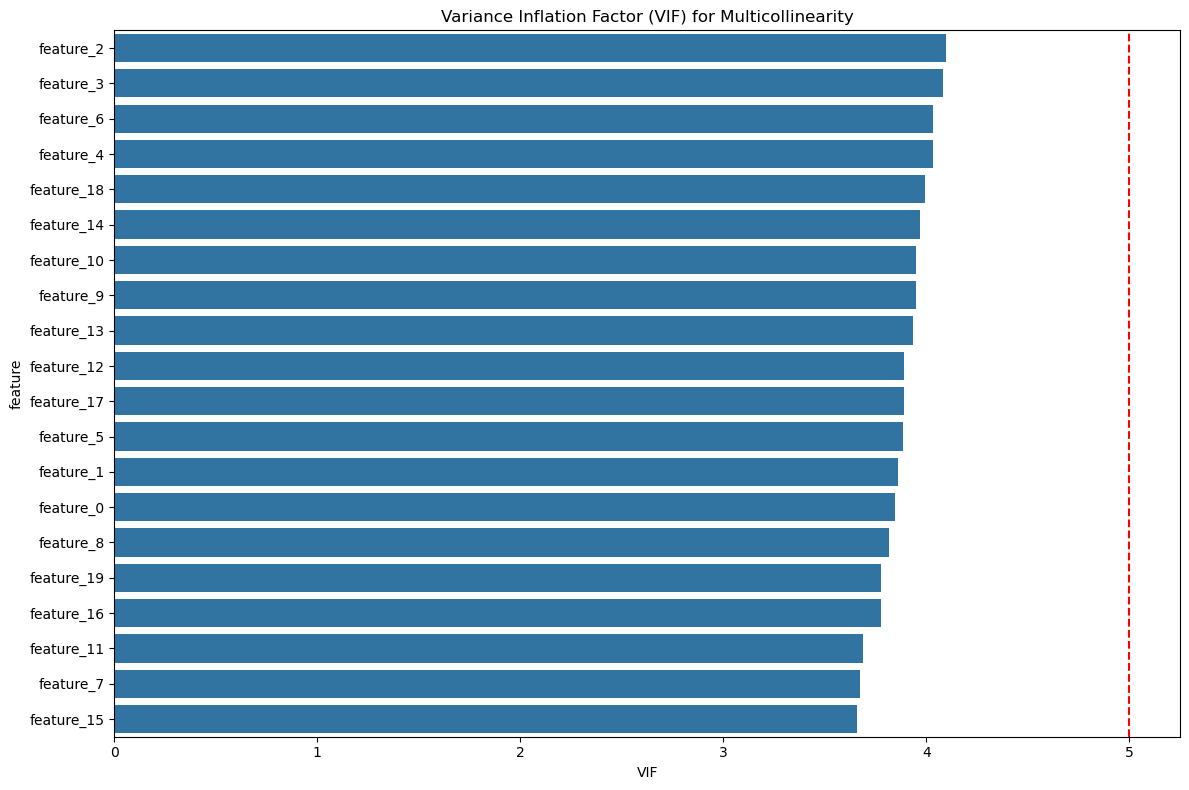

In [12]:
summary_stats, correlations, outliers_summary, feature_importance, normality_tests = analyze_dataframe(data)

* Features 2 has high correlation with dependent variable
* Features 13, 9, 11 have moderate correlation with dependent variable. The mentioned features should play significantly in model interpretation for model inference in production.
* Features have significantly different scales which suggests that feature scaling (e.g., standardization or normalization) is necessary to improve model performance.
* The target variable appears to have a much smaller spread compared to many features.
* Features with similar spreads and central tendencies like feature_2, feature_3, and feature_6 may indicate potential multicollinearity
* All features have VIF values below 5, meaning there is no severe multicollinearity issue among predictors. This is a good sign for model stability and interpretability.



In [39]:
# general stats
summary_stats

,count,mean,std,min,25%,50%,75%,max,missing,missing_pct,unique_values
feature_0,800.0,468.181612,270.797415,0.916648,239.330140,477.750620,704.650292,940.771543,0,0.0,800
feature_1,800.0,301.960218,170.691136,0.800119,157.338244,303.257176,448.878174,595.359858,0,0.0,800
feature_2,800.0,317.132996,176.501920,0.173025,167.516318,326.310194,474.484472,614.271632,0,0.0,800
feature_3,800.0,283.213456,157.698215,0.308823,151.302826,294.574403,415.806162,549.896216,0,0.0,800
feature_4,800.0,485.975950,272.594030,0.598527,250.305362,493.470486,720.747672,950.017444,0,0.0,800
feature_5,800.0,320.953859,185.157189,0.997347,158.374610,328.722464,480.076559,638.199832,0,0.0,800
feature_6,800.0,217.136330,123.660691,0.402436,106.876625,217.098090,327.411334,426.308251,0,0.0,800
feature_7,800.0,387.196289,235.131376,0.474825,195.037853,364.124238,588.565017,809.346792,0,0.0,800
feature_8,800.0,179.485453,104.059309,0.727850,94.220273,173.364771,268.790459,367.084755,0,0.0,800
feature_9,800.0,196.003058,111.042671,0.264253,95.052359,199.587048,291.546642,384.919108,0,0.0,800


In [ ]:
summary_stats, correlations, outliers_summary, feature_importance, normality_tests

### Correlation Techniques

* Pearson Correlation: 
* Spearman Correlation:
* Kendall Correlation:
* P-Values (Correlation Significance):  

In [14]:

def correlation_techniques(df, output_dir='data/eda/correlations/', save_plots=True):
    """
    Performs and visualizes multiple correlation techniques on a numeric dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing numeric data for correlation analysis
    output_dir : str, default='data/analysis_plots/correlations/'
        Directory where to save generated plots
    save_plots : bool, default=True
        Whether to save plots to disk
        
    Returns:
    --------
    tuple
        (pearson_corr, spearman_corr, kendall_corr, significant_correlations, correlation_comparison)
        All elements are pandas DataFrames containing correlation results
    """
    # Create directory if it doesn't exist and save_plots is True
    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create copy of dataframe to avoid modifying original
    df_corr = df.copy()
    
    # Calculate correlation matrices
    pearson_corr = df_corr.corr(method='pearson')
    spearman_corr = df_corr.corr(method='spearman')
    kendall_corr = df_corr.corr(method='kendall')
    
    # Calculate p-values for Pearson correlation
    pearson_p_values = pd.DataFrame(np.zeros_like(pearson_corr), 
                                   index=pearson_corr.index, 
                                   columns=pearson_corr.columns)
    
    # Calculate significance for Pearson correlations
    for i in range(len(pearson_corr.columns)):
        for j in range(len(pearson_corr.columns)):
            if i != j:  # Skip diagonal (self-correlations)
                stat, p = stats.pearsonr(df_corr.iloc[:, i].dropna(), 
                                          df_corr.iloc[:, j].dropna())
                pearson_p_values.iloc[i, j] = p
    
    # Create DataFrame for significant correlations
    significant_mask = (pearson_p_values < 0.05) & (pearson_p_values != 0)
    significant_correlations = pd.DataFrame({
        'feature1': [],
        'feature2': [],
        'pearson_corr': [],
        'spearman_corr': [],
        'kendall_corr': [],
        'p_value': [],
        'significant': []
    })
    
    # Find significant correlations (excluding self-correlations)
    sig_corr_rows = []
    for i in range(len(pearson_corr.columns)):
        for j in range(i+1, len(pearson_corr.columns)):  # Only upper triangle
            p_value = pearson_p_values.iloc[i, j]
            is_significant = significant_mask.iloc[i, j]
            
            sig_corr_rows.append({
                'feature1': pearson_corr.columns[i],
                'feature2': pearson_corr.columns[j],
                'pearson_corr': pearson_corr.iloc[i, j],
                'spearman_corr': spearman_corr.iloc[i, j],
                'kendall_corr': kendall_corr.iloc[i, j],
                'p_value': p_value,
                'significant': is_significant
            })
    
    significant_correlations = pd.DataFrame(sig_corr_rows).sort_values('pearson_corr', 
                                                                        key=abs, 
                                                                        ascending=False)
    
    # Create correlation comparison dataframe
    correlation_comparison = pd.DataFrame({
        'feature_pair': [f"{row['feature1']} - {row['feature2']}" for _, row in significant_correlations.iterrows()],
        'pearson': significant_correlations['pearson_corr'],
        'spearman': significant_correlations['spearman_corr'],
        'kendall': significant_correlations['kendall_corr']
    })
    
    # Visualizations
    print("Generating correlation visualizations...")
    
    # 1. Pearson correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(pearson_corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.title('Pearson Correlation Coefficient\n(Linear relationship)')
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}pearson_correlation.png", dpi=300, bbox_inches='tight')
    
    # 2. Spearman correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(spearman_corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.title('Spearman Rank Correlation\n(Monotonic relationship)')
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}spearman_correlation.png", dpi=300, bbox_inches='tight')
    
    # 3. Kendall correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(kendall_corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(kendall_corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.title('Kendall Tau Correlation\n(Ordinal correlation)')
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}kendall_correlation.png", dpi=300, bbox_inches='tight')
    
    # 4. Correlation significance visualization
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(pearson_p_values, dtype=bool))
    
    # Create a custom colormap for p-values (green for significant, red for non-significant)
    significant_cmap = plt.cm.RdYlGn_r
    
    # Plot p-values heatmap
    sns.heatmap(pearson_p_values, mask=mask, cmap=significant_cmap, 
                annot=True, square=True, linewidths=.5, 
                cbar_kws={"shrink": .5, "label": "p-value"}, 
                vmin=0, vmax=0.10)
    
    plt.title('Correlation Significance (p-values)\nValues < 0.05 are statistically significant')
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}correlation_significance.png", dpi=300, bbox_inches='tight')
    
    # 5. Top 10 strongest correlations bar chart
    plt.figure(figsize=(14, 8))
    top_correlations = significant_correlations.head(10).copy()
    top_correlations['abs_pearson'] = abs(top_correlations['pearson_corr'])
    top_correlations = top_correlations.sort_values('abs_pearson', ascending=True)
    
    bars = plt.barh(
        [f"{row['feature1']} - {row['feature2']}" for _, row in top_correlations.iterrows()],
        top_correlations['pearson_corr'],
        color=[plt.cm.RdBu(int((corr + 1) * 0.5 * 255)) for corr in top_correlations['pearson_corr']]
    )
    
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Pearson Correlation Coefficient')
    plt.title('Top 10 Strongest Feature Correlations')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}top_correlations.png", dpi=300, bbox_inches='tight')
    
    # 6. Correlation methods comparison for top features
    top_features_comparison = correlation_comparison.head(10)
    
    # Reshape for plotting
    top_features_comparison_melted = pd.melt(
        top_features_comparison, 
        id_vars=['feature_pair'], 
        value_vars=['pearson', 'spearman', 'kendall'],
        var_name='method', 
        value_name='correlation'
    )
    
    plt.figure(figsize=(14, 10))
    sns.barplot(x='correlation', y='feature_pair', hue='method', 
                data=top_features_comparison_melted,
                palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
    
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Comparison of Correlation Methods for Top Feature Pairs')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Feature Pair')
    plt.legend(title='Correlation Method')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    if save_plots:
        plt.savefig(f"{output_dir}correlation_methods_comparison.png", dpi=300, bbox_inches='tight')
    
    # 7. Scatterplot matrix for top correlated features
    if significant_correlations.shape[0] > 0:
        # Get top correlated features (unique list from top 5 correlations)
        top_feature_pairs = significant_correlations.head(5)
        top_features = set()
        for _, row in top_feature_pairs.iterrows():
            top_features.add(row['feature1'])
            top_features.add(row['feature2'])
        
        top_features = list(top_features)[:5]  # Limit to 5 features for clarity
        
        if len(top_features) >= 2:
            plt.figure(figsize=(15, 15))
            scatter_plot = sns.pairplot(
                df_corr[top_features], 
                kind='scatter', 
                diag_kind='kde',
                plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k', 'linewidth': 0.5},
                diag_kws={'fill': True, 'linewidth': 1, 'alpha': 0.8}
            )
            
            # Add correlation coefficient to each scatter plot
            for i, j in zip(*np.triu_indices_from(scatter_plot.axes, k=1)):
                ax = scatter_plot.axes[i, j]
                x = df_corr[top_features].columns[j]
                y = df_corr[top_features].columns[i]
                
                pearson_r = stats.pearsonr(df_corr[x].dropna(), df_corr[y].dropna())[0]
                spearman_r = stats.spearmanr(df_corr[x].dropna(), df_corr[y].dropna())[0]
                
                ax.annotate(f'Pearson: {pearson_r:.2f}\nSpearman: {spearman_r:.2f}', 
                            xy=(0.05, 0.95), xycoords='axes fraction',
                            ha='left', va='top',
                            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))
            
            plt.suptitle('Scatter Matrix of Top Correlated Features', y=1.02, fontsize=16)
            
            if save_plots:
                plt.savefig(f"{output_dir}top_features_pairplot.png", dpi=300, bbox_inches='tight')
    
    # Show plots if not saving
    if not save_plots:
        plt.show()
    
    print("Correlation analysis complete!")
    
    return (pearson_corr, spearman_corr, kendall_corr, significant_correlations, correlation_comparison)

Generating correlation visualizations...
Correlation analysis complete!


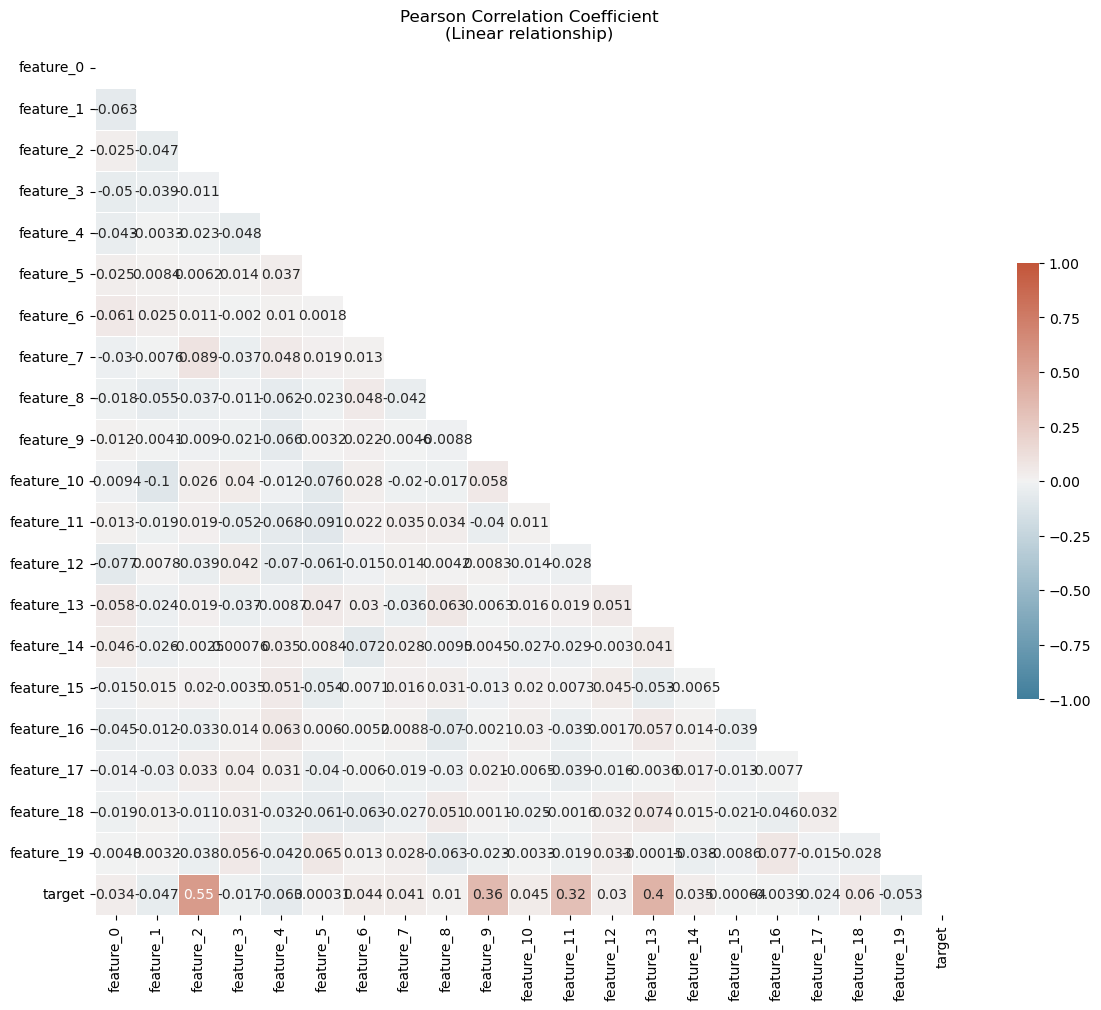

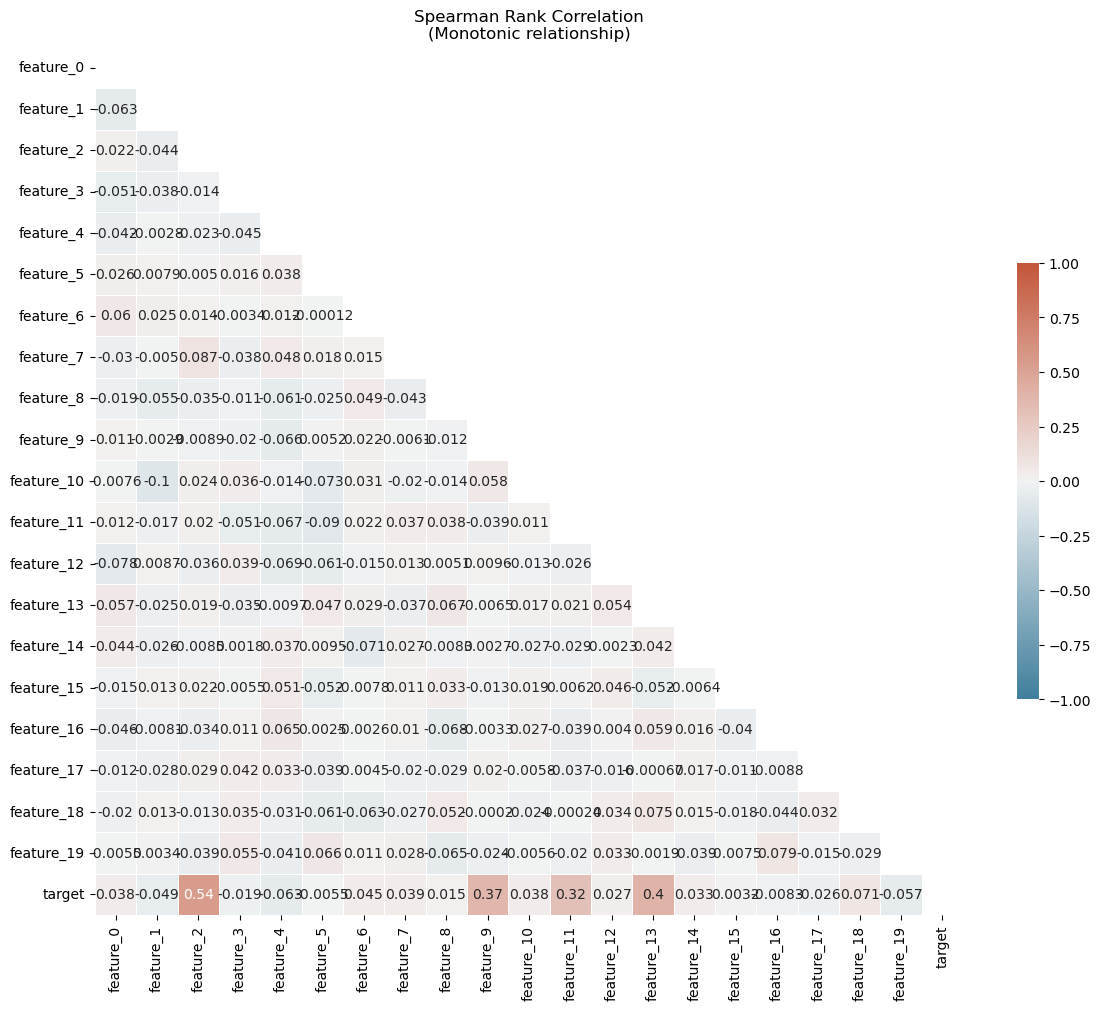

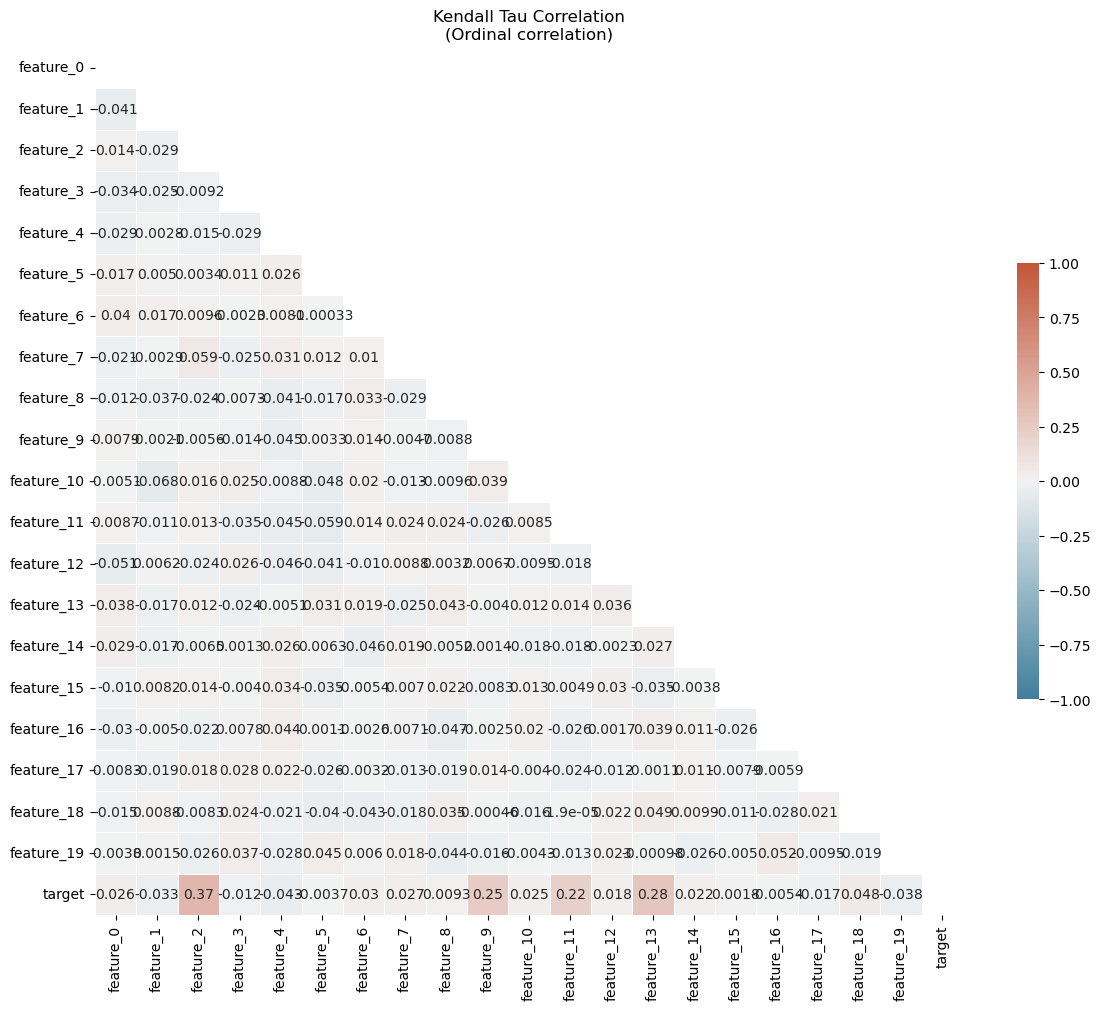

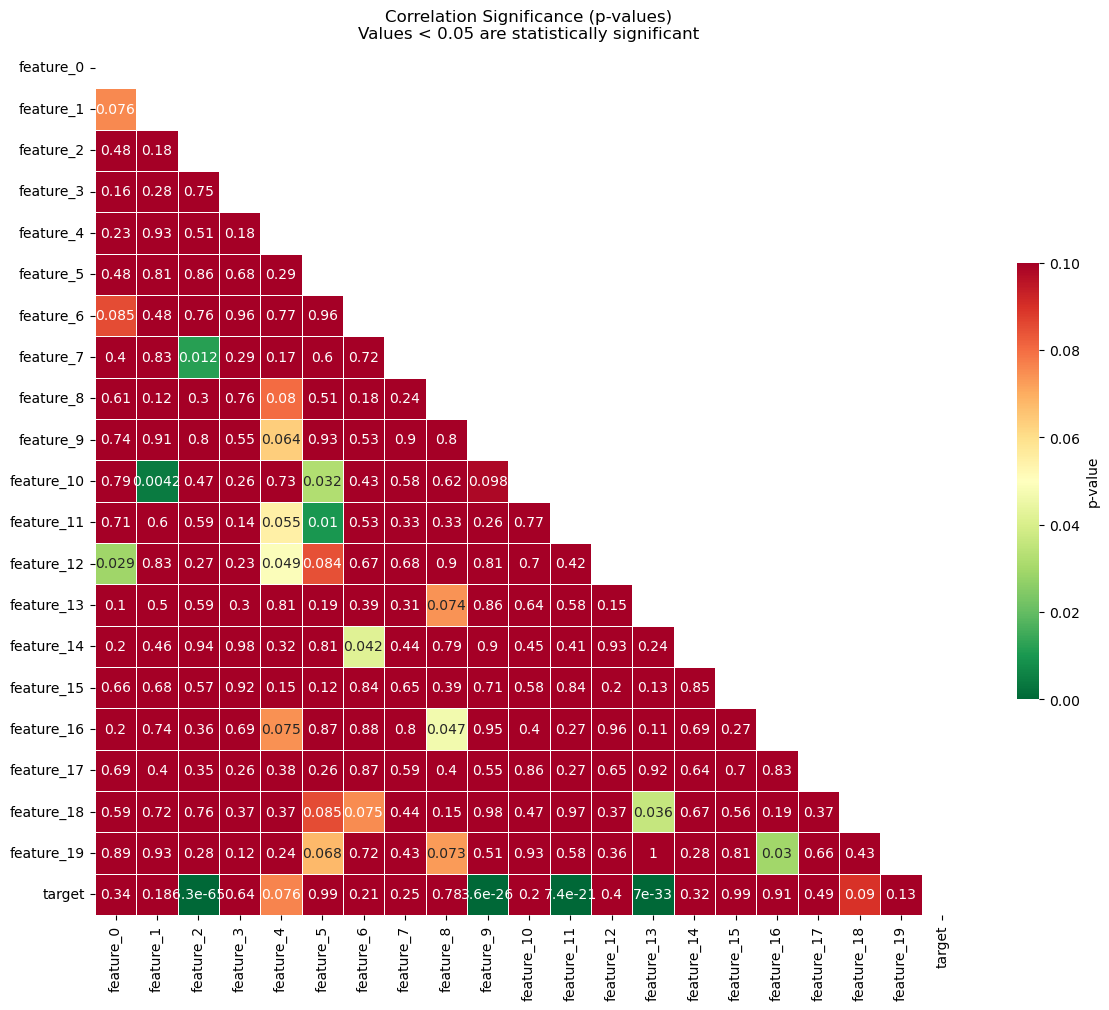

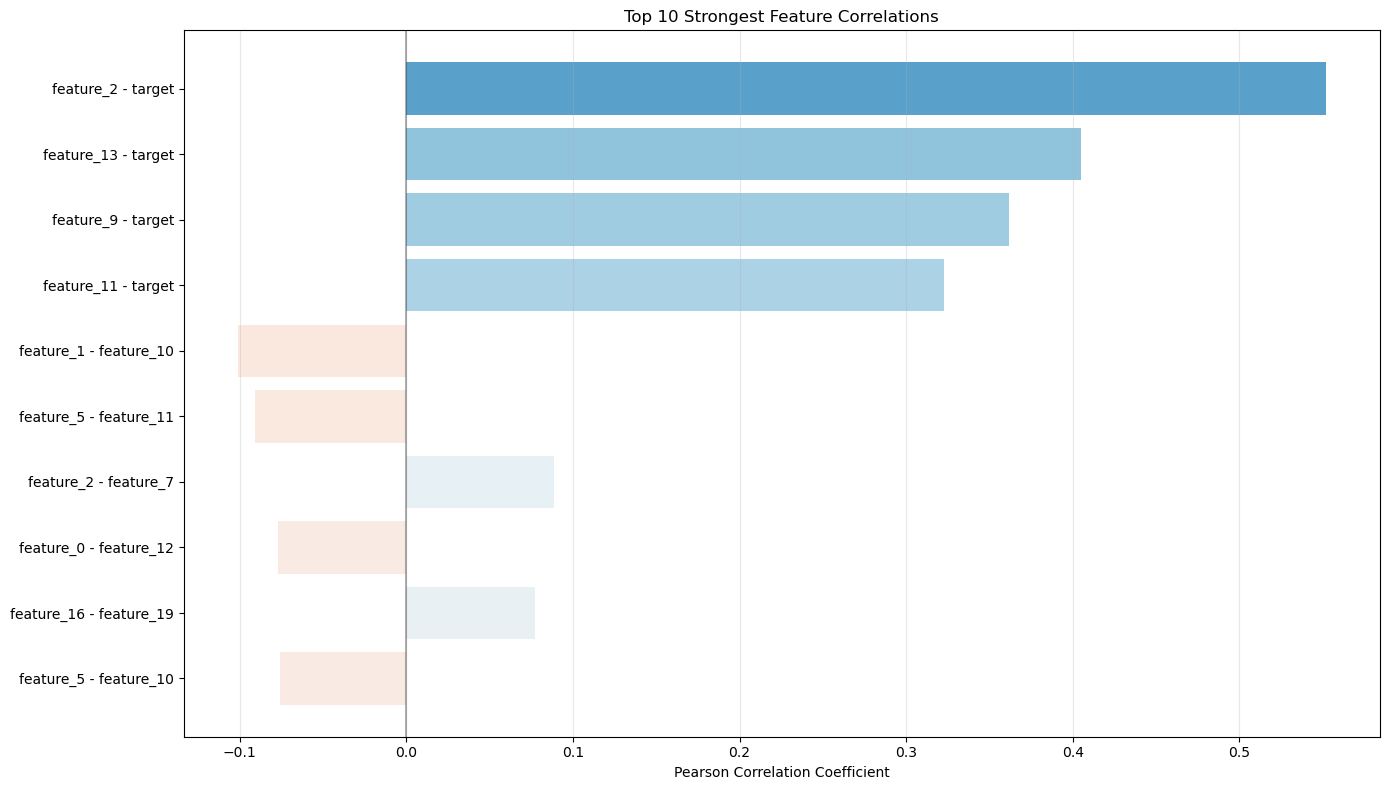

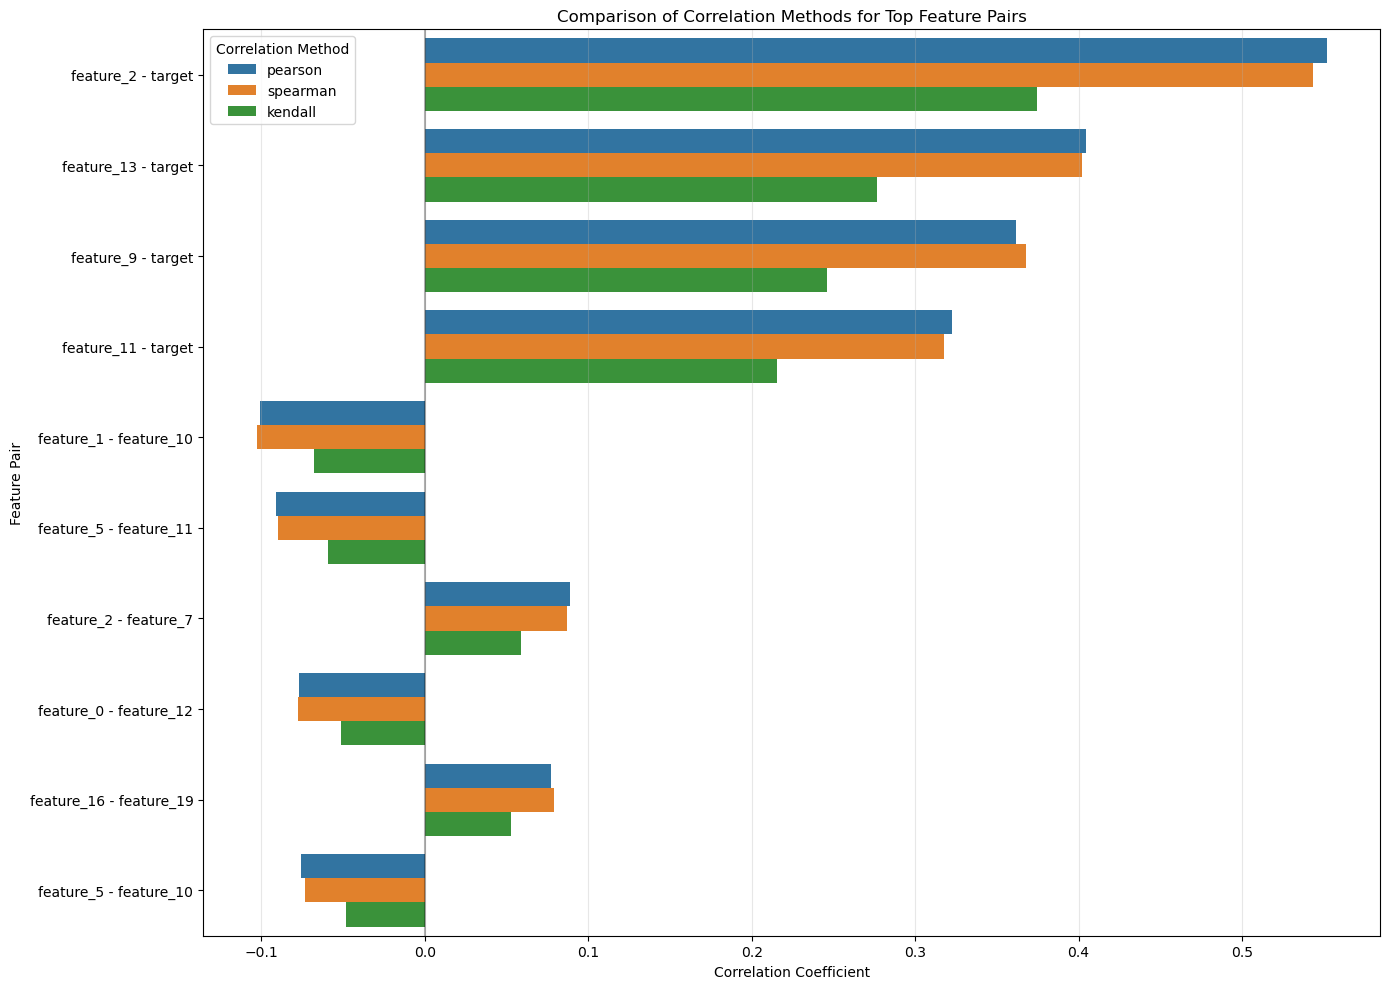

<Figure size 1500x1500 with 0 Axes>

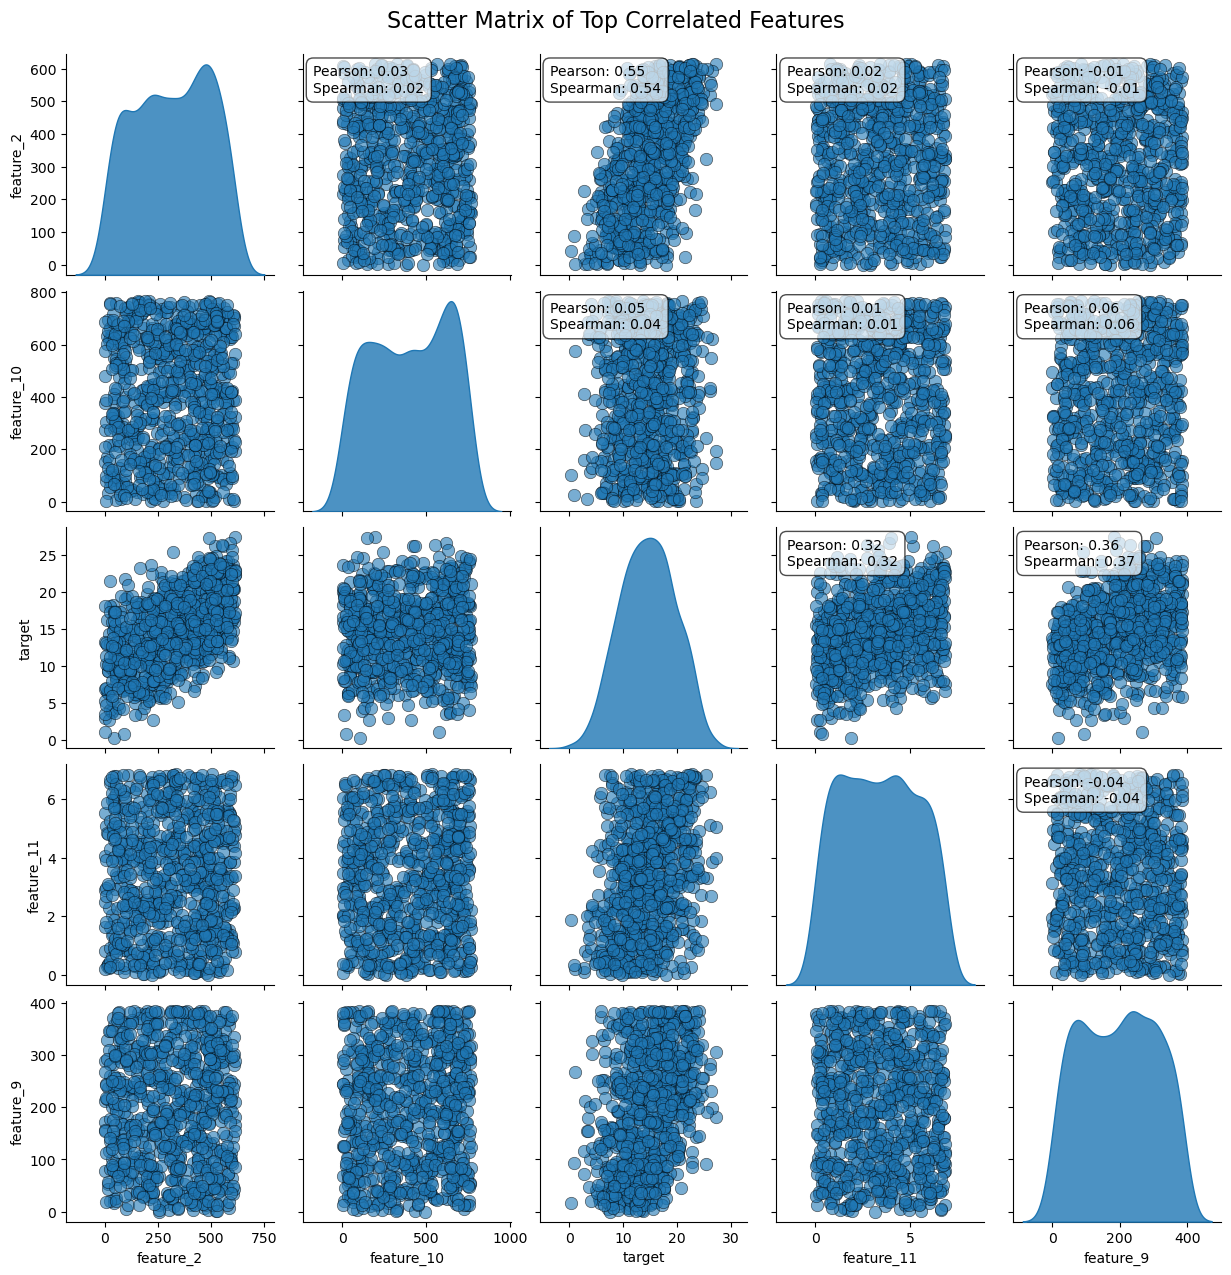

In [15]:
(pearson_corr, spearman_corr, kendall_corr, significant_correlations, correlation_comparison) = correlation_techniques(data)

* Feature_2, Feature_10, Feature_13: These have the highest Pearson correlation with the target (~0.55, 0.36, 0.4 respectively) and very low p-values (< 0.05), making them strong candidates for predictive modeling.
Feature_11 (0.32 correlation, p < 0.05) is also statistically significant.

* Features like Feature_0, Feature_5, Feature_6, Feature_15, Feature_18, and Feature_19 have high p-values (> 0.05), indicating no statistically significant correlation with the target.

### Variance and Covariance

In [17]:
def analyze_variance(df, output_dir='data/eda/variance/', save_plots=True):
    """
    Perform variance and covariance analysis on a pandas DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing numerical data for analysis
    output_dir : str, default='data/analysis_plots/variance/'
        Directory to save generated plots
    save_plots : bool, default=True
        Whether to save the generated plots
        
    Returns:
    --------
    tuple : (variance_df, covariance_df, correlation_df)
        Three DataFrames containing variance, covariance, and correlation information
    """
    # Create output directory if it doesn't exist and save_plots is True
    if save_plots:
        Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Select only numeric columns for analysis
    numeric_df = df.select_dtypes(include=[np.number])
    
    if numeric_df.empty:
        raise ValueError("No numeric columns found in the DataFrame")
    
    # Calculate variance for each numeric column
    variance_df = pd.DataFrame({
        'column': numeric_df.columns,
        'variance': numeric_df.var(),
        'std_deviation': numeric_df.std(),
        'mean': numeric_df.mean(),
        'median': numeric_df.median(),
        'min': numeric_df.min(),
        'max': numeric_df.max(),
        'range': numeric_df.max() - numeric_df.min(),
        'iqr': numeric_df.quantile(0.75) - numeric_df.quantile(0.25)
    }).reset_index(drop=True)
    
    # Calculate covariance matrix
    covariance_matrix = numeric_df.cov()
    
    # Calculate correlation matrix
    correlation_matrix = numeric_df.corr()
    
    # Visualizations
    
    # 1. Variance bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='column', y='variance', data=variance_df)
    plt.title('Variance by Column')
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(output_dir, 'variance_barplot.png'))
    plt.show()
    
    # 2. Box plots for distribution and variance visualization
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=numeric_df)
    plt.title('Distribution and Variance Across Columns')
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(output_dir, 'boxplot_distribution.png'))
    plt.show()
    
    # 3. Heatmap of covariance matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Covariance Matrix Heatmap')
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(output_dir, 'covariance_heatmap.png'))
    plt.show()
    
    # 5. Pairplot for multi-variable relationships
    if len(numeric_df.columns) <= 10:  # Only create pairplot if there aren't too many columns
        plt.figure(figsize=(16, 14))
        pairplot = sns.pairplot(numeric_df)
        plt.suptitle('Pairwise Relationships', y=1.02)
        if save_plots:
            pairplot.savefig(os.path.join(output_dir, 'pairplot.png'))
        plt.show()
    
    # 6. Standard deviation comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='column', y='std_deviation', data=variance_df)
    plt.title('Standard Deviation by Column')
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(output_dir, 'std_deviation_barplot.png'))
    plt.show()
    
    # Return the summary dataframes
    return variance_df, covariance_matrix

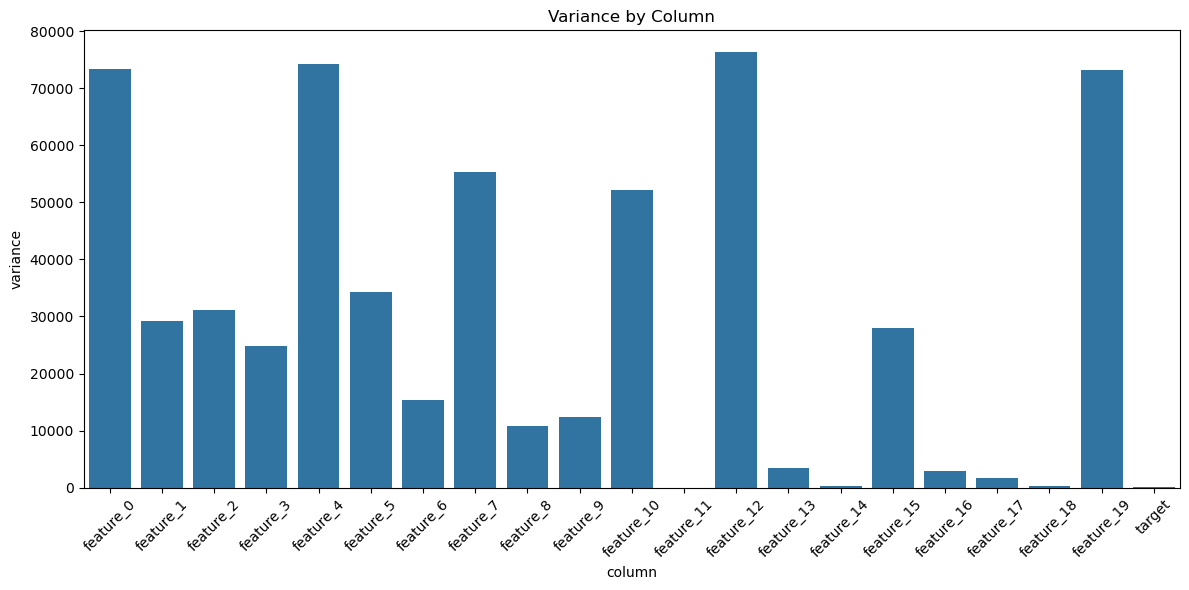

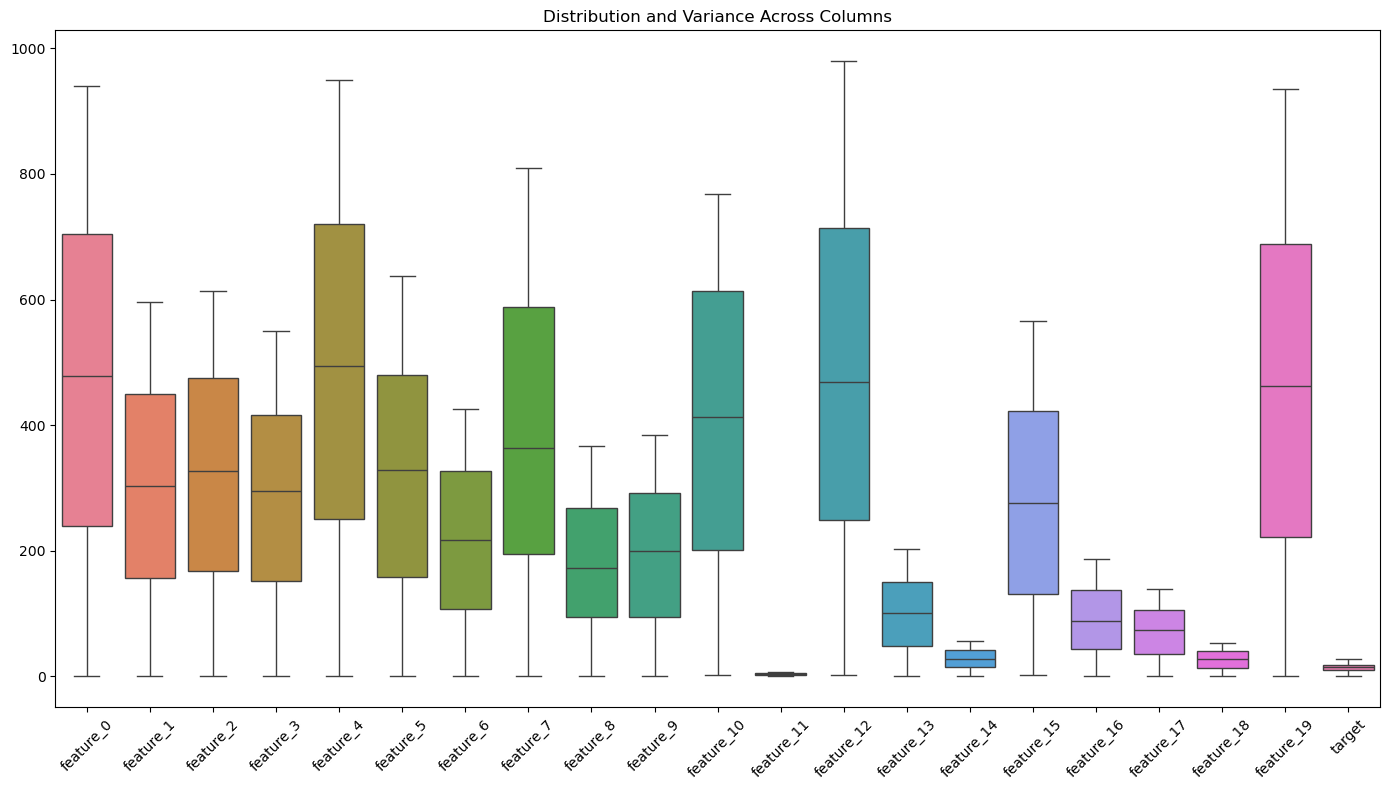

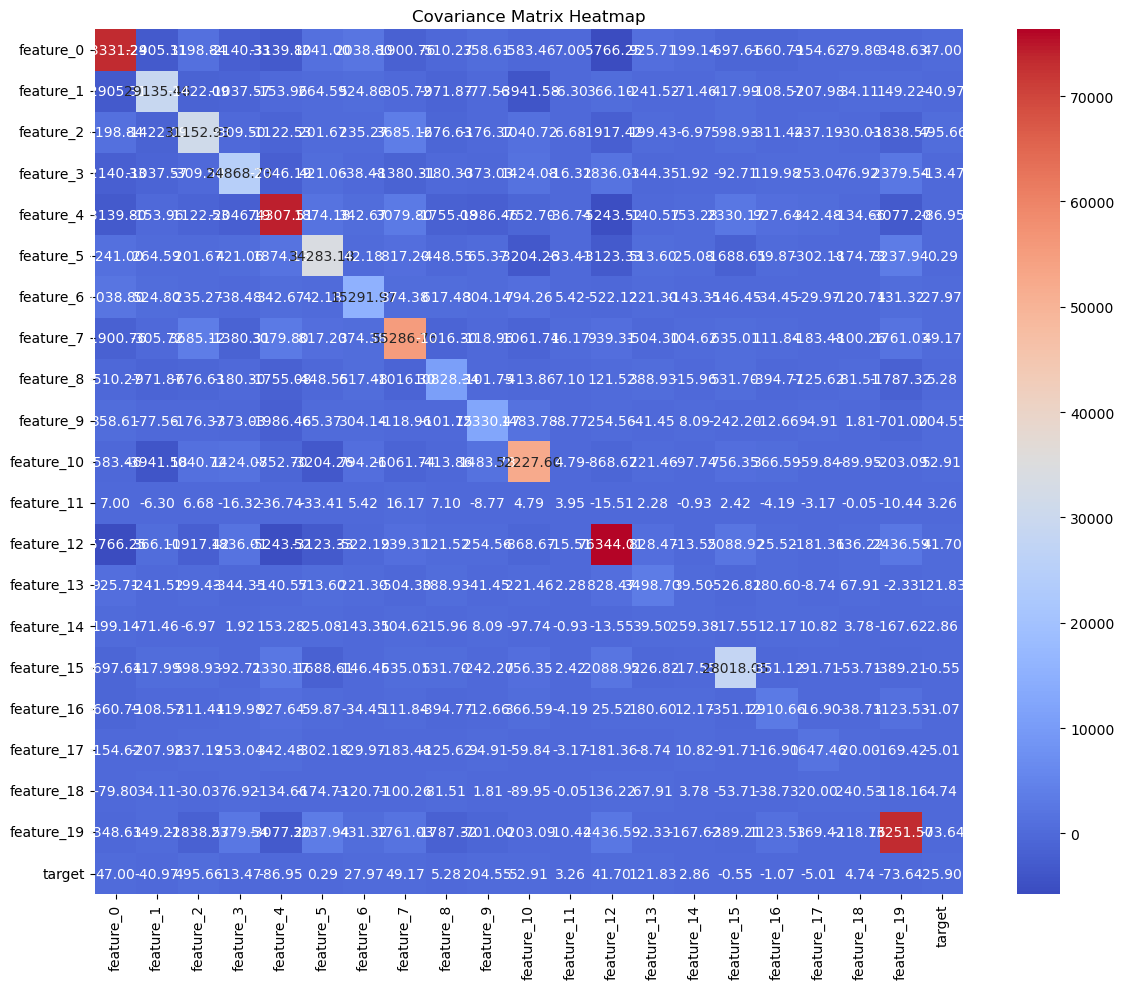

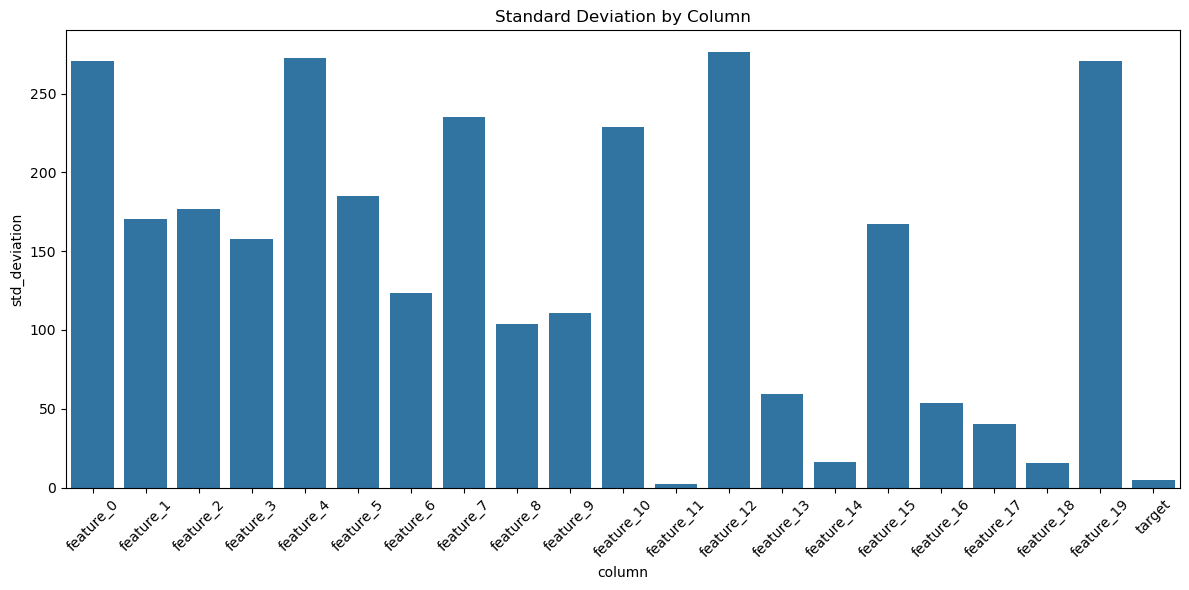

In [18]:
variance_df, covariance_matrix = analyze_variance(data)

### Pairplot

In [26]:
def visualize_numeric_data(df, output_dir='data/eda/pairplot/', save_plots=True):
    """
    Applies pairplot and scatter plot on a tabular numeric dataset.
    
    Parameters:
    - df: pandas DataFrame, the input dataset containing numeric columns.
    - output_dir: str, the directory where plots will be saved. Default is 'data/eda/pairplot/'.
    - save_plots: bool, whether to save the plots or not. Default is True.
    
    Returns:
    - tuple: (key_insights, df)
      - key_insights: pandas DataFrame, containing key insights from the dataset.
      - df: pandas DataFrame, the original dataset.
    """
    
    # Ensure the output directory exists
    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Pairplot
    pairplot_path = os.path.join(output_dir, 'pairplot.png')
    sns.pairplot(df)
    if save_plots:
        plt.savefig(pairplot_path)
    plt.close()
    
    # Scatter plot for each pair of numeric columns
    scatter_plots_dir = os.path.join(output_dir, 'scatter_plots')
    if save_plots and not os.path.exists(scatter_plots_dir):
        os.makedirs(scatter_plots_dir)
    
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for i in range(len(numeric_columns)):
        for j in range(i + 1, len(numeric_columns)):
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=df[numeric_columns[i]], y=df[numeric_columns[j]])
            plt.title(f'Scatter Plot: {numeric_columns[i]} vs {numeric_columns[j]}')
            if save_plots:
                scatter_plot_path = os.path.join(scatter_plots_dir, f'scatter_{numeric_columns[i]}_vs_{numeric_columns[j]}.png')
                plt.savefig(scatter_plot_path)
            plt.close()
    
    # Generate key insights
    key_insights = df.describe().transpose()
    key_insights['skewness'] = df.skew()
    key_insights['kurtosis'] = df.kurt()
    
    return key_insights, df

# Example usage:
# df = pd.read_csv('your_dataset.csv')
# insights, data = visualize_numeric_data(df)

In [27]:
key_insights, _ = visualize_numeric_data(data)

In [ ]:
key_insights

### Distribution Analysis

### Statistical Tests

### Unsupervised Learning

### Outlier Detection

## Preprocessing

### Data Cleaning

No missing values/NULL values in data features

In [30]:
# calcular porcentaje de missing values y NULLs en cada columna
porcentaje_missing = data.isna().mean() * 100

# Sort the variables by missing percentage in descending order
porcentaje_missing.sort_values(ascending=False, inplace=True)

# ver variables por porcentaje de NA/NULL
print('porcentaje missing NA',porcentaje_missing)

porcentaje missing NA feature_0     0.0
feature_11    0.0
feature_19    0.0
feature_18    0.0
feature_17    0.0
feature_16    0.0
feature_15    0.0
feature_14    0.0
feature_13    0.0
feature_12    0.0
feature_10    0.0
feature_1     0.0
feature_9     0.0
feature_8     0.0
feature_7     0.0
feature_6     0.0
feature_5     0.0
feature_4     0.0
feature_3     0.0
feature_2     0.0
target        0.0
dtype: float64


### Standarization

In [31]:
def standardize(df, numeric_variables):
    """
    Function that standardizes numeric variables of a DataFrame using StandardScaler.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data to process.
    numeric_variables : list
        List with the names of the numeric columns to standardize.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with transformed numeric variables, where each variable
        will have mean 0 and standard deviation 1.
    """
    # Create Pipeline with StandardScaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    # Create ColumnTransformer to apply transformation only to numeric columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_variables)
        ],
        remainder='passthrough'  # Leave the rest of the columns unchanged
    )
    
    # Apply the transformation
    transformed_data = preprocessor.fit_transform(df)
    
    # Get names of columns that won't be transformed
    other_columns = [col for col in df.columns if col not in numeric_variables]
    
    # Create a new DataFrame with the transformed data
    # First come the transformed columns and then those that remain unchanged
    final_columns = numeric_variables + other_columns
    standardized_df = pd.DataFrame(transformed_data, columns=final_columns, index=df.index)
    
    return standardized_df

In [32]:
# standarize all feature columns (everything except 'target')
all_columns = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 
               'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 
               'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 
               'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 
               'target']

# Extract all features except the target
features_to_standardize = [col for col in all_columns if col != 'target']

In [33]:
standardized_df = standardize(data, features_to_standardize)
standardized_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,-0.131936,-0.073789,0.930785,0.479329,1.162466,-0.779245,-1.169156,1.420405,-1.376593,-1.011362,...,0.510386,0.133804,-1.361594,-0.942666,-1.403947,-1.025603,-1.236854,-0.875582,-0.268112,14.364922
1,0.182592,0.167003,1.523809,-1.653109,-1.160555,0.079159,0.544694,1.535867,-1.017210,1.461110,...,1.103540,-1.727010,-1.343029,-0.658247,-1.646802,1.416228,0.112553,-1.606794,-0.566789,19.984801
2,-1.029983,1.476856,-0.857746,-0.512359,-1.135292,0.001087,1.538573,-0.961556,0.988358,0.230396,...,0.586502,0.369323,0.026788,-1.719850,1.253297,0.487305,-1.590263,-0.430466,-1.605898,12.944351
3,-0.853103,-0.621776,0.564762,1.177132,0.461478,-0.105610,0.200224,-1.436688,-0.548959,-1.641610,...,1.081190,-1.574711,1.628046,1.199359,0.802291,-0.446532,1.102069,-1.190843,-0.254273,14.792440
4,0.497597,-1.675751,-0.540689,0.396905,0.266542,-0.239134,1.544975,-1.565234,-0.391519,-0.444619,...,-0.622858,-1.253937,1.649769,-0.127784,-0.992809,1.501638,0.368373,0.203401,0.624500,11.802634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.740310,1.476814,1.280988,-1.343003,-0.483624,0.119919,0.134291,0.141171,1.758621,1.029353,...,0.147834,0.846329,0.993317,-0.145340,-0.800524,0.677224,1.276899,1.388761,-0.585222,23.716818
796,0.078306,-1.690825,-1.115392,-0.607038,-0.279020,1.093574,0.320291,-0.196188,-1.188859,1.685307,...,0.035730,-0.297106,0.182170,-0.696532,0.042276,0.367674,1.319414,1.451897,-0.903073,16.515457
797,1.730472,-0.948572,-0.587772,1.133429,-1.465427,-1.447632,0.193440,-0.034781,-0.377364,0.998966,...,0.495826,1.436985,-0.953838,-0.679365,1.671047,0.166653,0.681364,1.125711,1.432179,12.642383
798,1.166527,1.029229,-0.568296,-0.683907,-0.505695,1.475481,-1.310850,-0.684423,1.446115,0.959222,...,0.240278,-0.561981,-1.036316,1.126939,0.451358,0.095632,1.081171,1.540636,0.910636,16.186675


### X features - y target

In [ ]:
# Define the directory path
directory = 'data/bronze'

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the file
data.to_csv(f'{directory}/data_bronze.csv', index=False)

## Model Training

### Model Tunning

### Model Selection

#### Evaluation Metrics

## Model Evaluation

### Model Performance

### Model Interpretation

## Model Deployment